In [1]:
GPU_NUM = 1
GPU_ID = 0
import torch
import os
import sys
from re import I
os.environ["CUDA_VISIBLE_DEVICES"]=f"{GPU_NUM}"
#%env CUDA_VISIBLE_DEVICES=3
#torch.cuda.set_device(GPU_NUM)
device = f'cuda:{GPU_ID}'
sys.path.append('../')
from vq_gan_3d.model.vqgan import VQGAN
from dataset import MRNetDataset, BRATSDataset, ADNIDataset, DUKEDataset
import matplotlib.pyplot as plt
import SimpleITK as sitk
from ddpm import Unet3D, GaussianDiffusion, Trainer
import pytorch_ssim
from train.get_dataset import get_dataset
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import imageio
import matplotlib.animation as animation


/home/ge.polymtl.ca/p120530/.conda/envs/nomedicaldiffusion/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DDPM_CHECKPOINT = '/home/ge.polymtl.ca/p120530/Training/Counterfactual_synthesis_for_lesion_segmentation/checkpoints/2705_model-99.pt'
VQGAN_CHECKPOINT = "/home/ge.polymtl.ca/p120530/Training/Counterfactual_synthesis_for_lesion_segmentation/checkpoints/2105_e533_rc_0.12.ckpt"

USE_DATASET='BIDS'

if USE_DATASET=='LIDC':
	DDPM_CHECKPOINT = '/data/home/firas/Desktop/work/other_groups/medicaldiffusion/checkpoints/ddpm/LIDC/model-78.pt'
	VQGAN_CHECKPOINT = '/data/home/firas/Desktop/work/other_groups/medicaldiffusion/checkpoints/vq_gan/LIDC/lightning_logs/version_0/checkpoints/epoch\=100-step\=102000-train/recon_loss\=0.33.ckpt'

	with initialize(config_path="../config/"):
			cfg=compose(config_name="base_cfg.yaml", overrides=[
				"model=ddpm",
				"dataset=lidc",
				f"model.vqgan_ckpt={VQGAN_CHECKPOINT}",
				"model.diffusion_img_size=16",
				"model.diffusion_depth_size=16",
				"model.diffusion_num_channels=8",
				"model.dim_mults=[1,2,4,8]",
				"model.batch_size=40 ",
				"model.gpus=0 ",
				])

elif USE_DATASET=='ADNI':
	DDPM_CHECKPOINT = '/data/home/firas/Desktop/work/other_groups/medicaldiffusion/checkpoints/ddpm/ADNI/roi/model-34.pt'
	VQGAN_CHECKPOINT = '/data/home/firas/Desktop/work/other_groups/medicaldiffusion/checkpoints/vq_gan/ADNI/roi/lightning_logs/version_1/checkpoints/epoch\=99-step\=99000-train/recon_loss\=0.05.ckpt'

	with initialize(config_path="../config/"):
			cfg=compose(config_name="base_cfg.yaml", overrides=[
				"model=ddpm",
			 	"dataset=adni",
			 	f"model.vqgan_ckpt={VQGAN_CHECKPOINT}",
			 	"model.diffusion_img_size=32",
			 	"model.diffusion_depth_size=32",
			 	"model.diffusion_num_channels=8",
			 	"model.dim_mults=[1,2,4,8]",
			 	"model.batch_size=40 ",
			 	"model.gpus=0 ",
				])

elif USE_DATASET=='DUKE':
	DDPM_CHECKPOINT = '/data/home/firas/Desktop/work/other_groups/medicaldiffusion/checkpoints/ddpm/DUKE/model-83.pt'
	VQGAN_CHECKPOINT = '/data/home/firas/Desktop/work/other_groups/medicaldiffusion/checkpoints/vq_gan/DUKE/lightning_logs/version_0/checkpoints/epoch\=58-step\=108000-train/recon_loss\=0.17.ckpt'

	with initialize(config_path="../config/"):
			cfg=compose(config_name="base_cfg.yaml", overrides=[
				"model=ddpm",
			 	"dataset=duke",
			 	f"model.vqgan_ckpt={VQGAN_CHECKPOINT}",
			 	"model.diffusion_img_size=32",
			 	"model.diffusion_depth_size=4",
			 	"model.diffusion_num_channels=8",
			 	"model.dim_mults=[1,2,4,8]",
			 	"model.batch_size=40 ",
			 	"model.gpus=0 ",
				])

elif USE_DATASET=='MRNet':
	DDPM_CHECKPOINT = '/data/home/firas/Desktop/work/other_groups/medicaldiffusion/checkpoints/ddpm/MRNet/model-77.pt'
	VQGAN_CHECKPOINT = '/data/home/firas/Desktop/work/other_groups/medicaldiffusion/checkpoints/vq_gan/MRNet/lightning_logs/version_0/checkpoints/epoch\=126-step\=114000-train/recon_loss\=0.47.ckpt'

	with initialize(config_path="../config/"):
			cfg=compose(config_name="base_cfg.yaml", overrides=[
				"model=ddpm",
			 	"dataset=mrnet",
			 	f"model.vqgan_ckpt={VQGAN_CHECKPOINT}",
			 	"model.diffusion_img_size=32",
			 	"model.diffusion_depth_size=4",
			 	"model.diffusion_num_channels=8",
			 	"model.dim_mults=[1,2,4,8]",
			 	"model.batch_size=40 ",
			 	"model.gpus=0 ",
				])
			
if USE_DATASET=='BIDS':
	with initialize(config_path="../config/"):
			cfg=compose(config_name="base_cfg.yaml", overrides=[
				"model=ddpm",
				"dataset=bids",
				"dataset.root_dir=/home/ge.polymtl.ca/p120530/Training/sci-paris",
				f"model.vqgan_ckpt={VQGAN_CHECKPOINT}",
				"model.diffusion_img_size=128",
				"model.diffusion_depth_size=8",
				"model.diffusion_num_channels=8",
				"model.dim_mults=[1,2,4,8]",
				"model.batch_size=40 ",
				f"model.gpus={GPU_ID} ",
				])

if USE_DATASET=='DEFAULT':
	with initialize(config_path="../config/"):
			cfg=compose(config_name="base_cfg.yaml", overrides=[
				"model=ddpm",
				"dataset=default",
				"dataset.root_dir=/home/ge.polymtl.ca/p120530/Training/Counterfactual_synthesis_for_lesion_segmentation/input_samples/sci-paris",
				f"model.vqgan_ckpt={VQGAN_CHECKPOINT}",
				"model.diffusion_img_size=128",
				"model.diffusion_depth_size=8",
				"model.diffusion_num_channels=8",
				"model.dim_mults=[1,2,4,8]",
				"model.batch_size=40 ",
				f"model.gpus={GPU_ID} ",
				])


/tmp/ipykernel_1687829/2164827831.py:75: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../config/"):


In [3]:
train_dataset, _, _ = get_dataset(cfg)

bjr
True
['T2w']
Found 14 files in /home/ge.polymtl.ca/p120530/Training/sci-paris
Found 14 files in /home/ge.polymtl.ca/p120530/Training/sci-paris


## Evaluate VQ-GAN

In [4]:
vqgan_ckpt = VQGAN_CHECKPOINT.replace("\\", "")
vqgan = VQGAN.load_from_checkpoint(vqgan_ckpt)
vqgan.decoding_diviser = 3
vqgan = vqgan.to(device)
vqgan.eval();

/home/ge.polymtl.ca/p120530/.conda/envs/nomedicaldiffusion/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ge.polymtl.ca/p120530/.conda/envs/nomedicaldiffusion/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from /home/ge.polymtl.ca/p120530/Training/Counterfactual_synthesis_for_lesion_segmentation/vq_gan_3d/model/cache/vgg.pth


In [5]:
"""with torch.no_grad():
	output_ = vqgan(input_)

sitk.WriteImage(sitk.GetImageFromArray(output_[1][0][0].cpu()), 'samples/output.nii')
sitk.WriteImage(sitk.GetImageFromArray(input_[0][0].cpu()), 'samples/input.nii')"""

"with torch.no_grad():\n\toutput_ = vqgan(input_)\n\nsitk.WriteImage(sitk.GetImageFromArray(output_[1][0][0].cpu()), 'samples/output.nii')\nsitk.WriteImage(sitk.GetImageFromArray(input_[0][0].cpu()), 'samples/input.nii')"

## Evaluate DDPM

In [6]:
model = Unet3D(
    dim=cfg.model.diffusion_img_size,
    dim_mults=cfg.model.dim_mults,
    channels=cfg.model.diffusion_num_channels,
).cuda(GPU_ID)

diffusion = GaussianDiffusion(
    model,
    vqgan_ckpt=cfg.model.vqgan_ckpt,
    image_size=cfg.model.diffusion_img_size,
    num_frames=cfg.model.diffusion_depth_size,
    channels=cfg.model.diffusion_num_channels,
    timesteps=cfg.model.timesteps,
    # sampling_timesteps=cfg.model.sampling_timesteps,
    loss_type=cfg.model.loss_type,
    # objective=cfg.objective
).cuda(GPU_ID)


trainer = Trainer(
    diffusion,
    cfg=cfg,
    dataset=train_dataset,
    train_batch_size=cfg.model.batch_size,
    save_and_sample_every=cfg.model.save_and_sample_every,
    train_lr=cfg.model.train_lr,
    train_num_steps=cfg.model.train_num_steps,
    gradient_accumulate_every=cfg.model.gradient_accumulate_every,
    ema_decay=cfg.model.ema_decay,
    amp=cfg.model.amp,
    num_sample_rows=cfg.model.num_sample_rows,
    #results_folder=cfg.model.results_folder,
    results_folder='samples',
    num_workers=cfg.model.num_workers,
    # logger=cfg.model.logger
)



loaded pretrained LPIPS loss from /home/ge.polymtl.ca/p120530/Training/Counterfactual_synthesis_for_lesion_segmentation/vq_gan_3d/model/cache/vgg.pth
found 14 videos as gif files at None


In [7]:
trainer.load(DDPM_CHECKPOINT, map_location=f'cuda:{GPU_ID}')


In [8]:
#Comparisons function between the original and the generated images

def unsigned_difference(volume1, volume2, segmentation = None):
    """ returns |volume1 - volume2| 
    if a segmentation is provided, the difference is only computed on the segmented region
    """
    if segmentation == None:
        segmentation = np.ones(volume1.shape)
    diff = (volume1 - volume2) 
    diff = np.abs(diff) * segmentation
    return diff

In [9]:
# diffusion functions

def img2img(sample, denoising = 0.2, comparison_mode = "Unsigned_difference", segmentation = None):
    """ Take a sample and a dataset and perform img2img diffusion,
    returns the input, the noised image before diffusion the output, and the comparison between input and ouput
    """
    input_ = torch.tensor(sample['data'][None]).to(device)
    noised_input = trainer.ema_model.noise_sample(input_image = input_, denoising = denoising, batch_size=1).unbind(0)[0].cpu().numpy()
    output = trainer.ema_model.sample(input_image = input_, denoising = denoising, batch_size=1).unbind(0)[0].cpu().numpy()
    input_ = input_.unbind(0)[0].cpu().numpy()
    if segmentation is not None:
        segmentation = torch.tensor(sample['segmentation'][None]).cpu().numpy()
    if comparison_mode == "Unsigned_difference":
        comparison = unsigned_difference(input_, output, segmentation = segmentation)
    else :
        # if comparison is not specified, return a zero array
        comparison = np.zeros(input_.shape)
    return input_, noised_input, output, comparison

def img2img_dataset(dataset, denoising = 0.2, comparison_mode = "Unsigned_difference", segmentation = None):
    """ Take a dataset and perform img2img diffusion on all the samples
    returns the inputs, the noised images before diffusion the outputs, and the comparisons between input and ouputs
    """
    inputs = []
    noised_inputs = []
    outputs = []
    comparisons = []
    for i in range(len(dataset)):
        input_, noised_input, output, comparison = img2img(i, dataset, denoising = denoising, comparison_mode = comparison_mode, segmentation = segmentation)
        inputs.append(input_)
        noised_inputs.append(noised_input)
        outputs.append(output)
        comparisons.append(comparison)
    return inputs, noised_inputs, outputs, comparisons

def img2img_denoising_range(sample, denoising_range, comparison_mode = "Unsigned_difference", segmentation = None):
    """ Take an image from a dataset and perform img2img diffusion for a range of denoising values,
    returns the input, the noised image before diffusion the output, and the comparison between input and ouput
    """
    noised_inputs = []
    outputs = []
    comparisons = []
    for denoising in denoising_range:
        input_, noised_input, output, comparison = img2img(sample, denoising = denoising, comparison_mode = comparison_mode, segmentation = segmentation)
        noised_inputs.append(noised_input)
        outputs.append(output)
        comparisons.append(comparison)
        
    return input_, noised_inputs, outputs, comparisons



In [10]:
#ploting functions

def re_orient(image):
    """ Take a 2D of a spinal coord as input oriented as expected by the model 
    and return the image oriented as expected by the conventions
    """
    return np.flip(np.rot90(image,1),1)

def normalize(image, min_ = -1, max_ = 1):
    """ Normalize the image between min_ and max_ values
    """
    return (image - np.min(image)) * (max_ - min_) / (np.max(image) - np.min(image)) + min_

def plot_img2img(input_, noised_input, output, comparison, output_file_name, denosing, mode = "gif", index = -1):
    """ Take the output of a img2img diffusion and plot the input, the noised input, the output and the comparison
    on the same figure. Save it to the given folder with appropriate name
    different modes are available : 
    - gif : all slices are displayed in a gif
    - static : only display the given slice (middle slice if index = -1)
    """
    fig, axs = plt.subplots(1, 4, figsize=(20,5))
    if mode == "gif":  

        # Initialize images and texts
        im = axs[0].imshow(re_orient(input_[0][0]), cmap='gray', vmin=-1, vmax=1)
        im1 = axs[1].imshow(re_orient(normalize(noised_input)[0][0]), cmap='gray', vmin=-1, vmax=1)
        im2 = axs[2].imshow(re_orient(output[0][0]), cmap='gray', vmin=-1, vmax=1)
        im3 = axs[3].imshow(re_orient(comparison[0][0]), cmap='gray', vmin=0, vmax=1)
        text = axs[0].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
        text1 = axs[1].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
        text2 = axs[2].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
        text3 = axs[3].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))

        # Add a title
        axs[0].set_title('Input (GT before noising)')
        axs[1].set_title(f'Noised input (noise level : {denosing})')
        axs[2].set_title(f'Output')
        axs[3].set_title(f'Comparison')

        # Update function for the animation
        def gif_update(i):
            im.set_array(re_orient(input_[0][i]))
            im1.set_array(re_orient(normalize(noised_input)[0][i]))
            im2.set_array(re_orient(output[0][i]))
            im3.set_array(re_orient(comparison[0][i]))
            text.set_text(f'Slice : {i}')
            text1.set_text(f'Slice : {i}')
            text2.set_text(f'Slice : {i}')
            text3.set_text(f'Slice : {i}')
            return [im, im1, im2, im3, text, text1, text2, text3]

        # Create the animation
        ani = animation.FuncAnimation(fig, gif_update, frames=len(output[0]), interval=200, blit=True)
        ani.save(f'{output_file_name}.gif')

    elif mode == "static":
        if index < 0:
            index = input_.shape[0]//2
        im = axs[2].imshow(re_orient(output[index]), cmap='gray', vmin=-1, vmax=1)
        im2 = axs[1].imshow(re_orient(noised_input[index]), cmap='gray', vmin=-1, vmax=1)
        im3 = axs[0].imshow(re_orient(input_[index]), cmap='gray', vmin=-1, vmax=1)
        im4 = axs[3].imshow(re_orient(comparison[index]), cmap='gray', vmin=0, vmax=1)
        axs[2].set_title(f'Output slice {index}')
        axs[1].set_title(f'Noised input slice {index}')
        axs[0].set_title(f'Input slice {index}')
        axs[3].set_title(f'Comparison slice {index}')
        plt.savefig(f'{output_file_name}.png')
    else:
        print("Mode not recognized, please choose between gif, middle or index")

def plot_img2img_denoising_range(input_, noised_inputs, outputs, comparisons, denoising_range, output_file_name, index = -1):
    """ Take the output of a img2img diffusion for a range of denoising values and plot the input, the noised input, the output and the comparison
    on the same figure. Save it to the given folder with appropriate name
    different modes are available : 
    """
    if index == -1:
        index = input_.shape[0]//2
    fig, axs = plt.subplots(1, 4, figsize=(20,5))
    for i in range(len(denoising_range)):
        # Initialize images and texts
        im = axs[2].imshow(re_orient(outputs[0][0][index]), cmap='gray', vmin=-1, vmax=1)
        im2 = axs[1].imshow(re_orient(normalize(noised_inputs[0])[0][index]), cmap='gray', vmin=-1, vmax=1)
        im3 = axs[0].imshow(re_orient(input_[0][index]), cmap='gray', vmin=-1, vmax=1)
        im4 = axs[3].imshow(re_orient(comparisons[0][0][index]), cmap='gray', vmin=0, vmax=1)
        text = axs[2].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=1))
        text2 = axs[1].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=1))
        text3 = axs[3].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=1))

        # Add a title
        axs[2].set_title(f'Output')
        axs[1].set_title(f'Noised input')
        axs[0].set_title('Input (GT before noising)')
        axs[3].set_title(f'Comparison')

        # Update function for the animation
        def gif_update(i):
            im.set_array(re_orient(outputs[i][0][index]))
            im2.set_array(re_orient(normalize(noised_inputs[i])[0][index]))
            im3.set_array(re_orient(input_[0][index]))
            im4.set_array(re_orient(comparisons[i][0][index]))
            text.set_text(f'Noise level : {round(denoising_range[i],2)*100}%')
            text2.set_text(f'Noise level : {round(denoising_range[i],2)*100}%')
            text3.set_text(f'Noise level : {round(denoising_range[i],2)*100}%')
            return [im, im2, im3, im4, text, text2, text3]

        # Create the animation
        ani = animation.FuncAnimation(fig, gif_update, frames=len(outputs), interval=300, blit=True)
        ani.save(f'{output_file_name}.gif')





In [11]:
# use the function to get the input, noised input, output and comparison
sample_index = 9
denosing = 0.01
sample = train_dataset[sample_index]
input_, noised_input, output, comparison = img2img(sample, denoising = denosing, comparison_mode = "Unsigned_difference")

/tmp/ipykernel_1687829/1808956753.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ = torch.tensor(sample['data'][None]).to(device)


3


sampling loop time step:   1%|          | 3/300 [00:01<01:45,  2.81it/s]


MovieWriter ffmpeg unavailable; using Pillow instead.


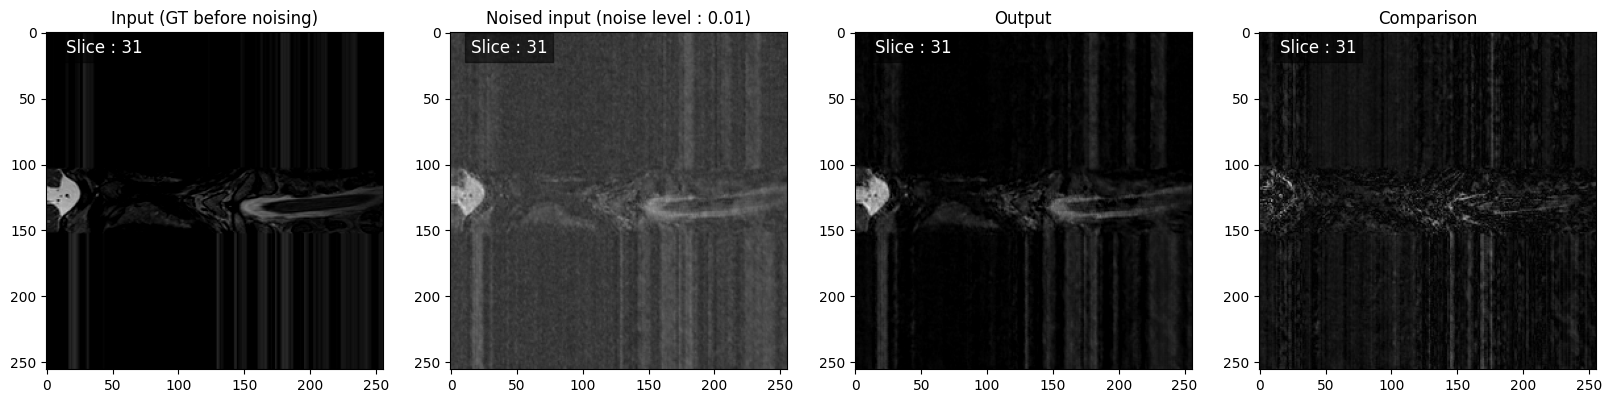

In [12]:
output_folder="/home/ge.polymtl.ca/p120530/Training/Counterfactual_synthesis_for_lesion_segmentation/infered_figures"
#plot the gif of the diffusion
plot_img2img(input_, noised_input, output, comparison, f"{output_folder}/gif_canproco_{sample_index}_d={str(round(denosing,2))}", denosing, mode = "gif")

In [13]:
# use the function to get the input, noised input, output and comparison for a range of denoising values
sample_index = 20
denoising_values = np.arange(0.0, 1.0, 0.05)
sample = train_dataset[sample_index]
input_, noised_inputs, outputs, comparisons = img2img_denoising_range(sample, denoising_values, comparison_mode = "Unsigned_difference")

IndexError: list index out of range

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


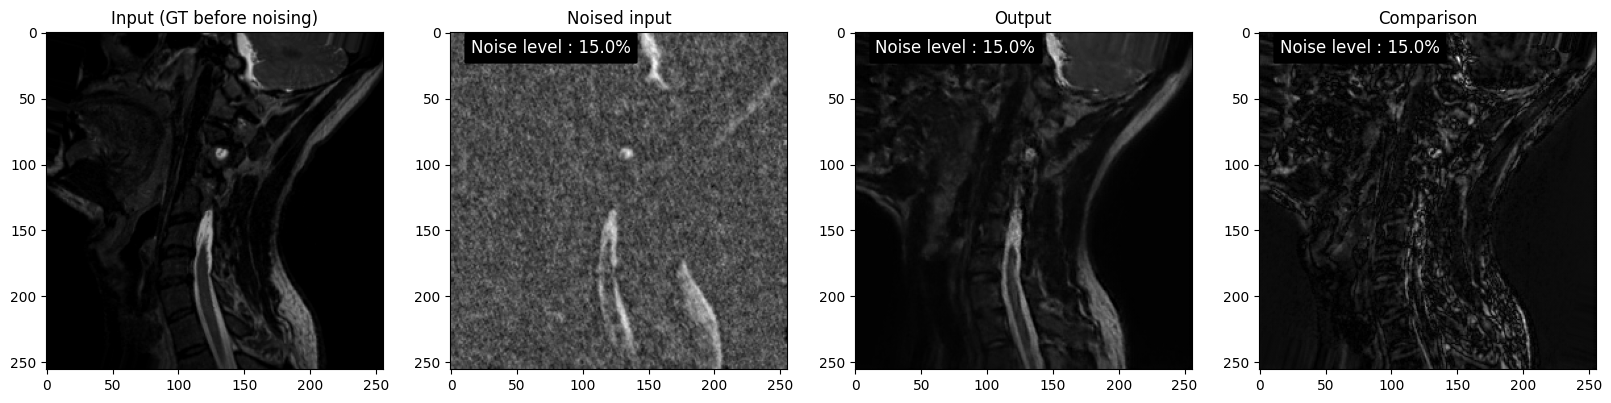

In [ ]:
output_folder="/home/ge.polymtl.ca/p120530/Training/Counterfactual_synthesis_for_lesion_segmentation/infered_figures"
#plot the gif of the diffusion for a range of denoising values
plot_img2img_denoising_range(input_, noised_inputs, outputs, comparisons, denoising_values, f"{output_folder}/gif_canproco_{sample_index}_d_range", index = 0)